This notebook was executed in google Colab. Data will not be provided as this notebook is merely to demonstrate the process of model training, evaluation and testing.

In [4]:
#execute code in google colab. 
from google.colab import drive
drive.mount('/content/drive')
!pip install pytorch_pretrained_vit

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Modules**

In [7]:
#################################
# import modules
#################################
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from pytorch_pretrained_vit import ViT
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

#additional modules
from datetime import datetime #for saving files
import pandas as pd
import torch
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


**Training functions**

In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False , saved_model=None):
    since = time.time()
    val_acc_history = []
    val_loss_history = []
    best_acc_valid = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc_valid:
                best_acc_valid = epoch_acc
                best_loss_valid = epoch_loss

                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    time_result = 'Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc_valid))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, time_result, best_acc_valid, best_loss_valid

In [9]:
#Flag for gradient descent
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
#Model for ViT
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "vit":
        """ 
        vit
        """
        model_ft = ViT('B_16_imagenet1k', pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 384
    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size#, copy.deepcopy(model_ft.state_dict()) #added deep model weights 
        #best_model_wts = copy.deepcopy(model.state_dict())

**Initialise global variables**

In [11]:
data_dir = "/content/drive/MyDrive/shared/samples_x384_all"  # for vit

# Variables
num_classes = 4
batch_size = 6 # vit <- resource max cap (don't have enough resources to increase)
num_epochs = 10
feature_extract = False # if true, then only update the reshaped layer param of the model

# Model
model_name = "vit"
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth


  0%|          | 0.00/331M [00:00<?, ?B/s]

Loaded pretrained weights.


**Data normalisation**

In [ ]:
def get_mean_std(loader,phase):
  channels_sum, channels_squared_sum, num_batches = 0, 0, 0
  
  for data,_ in loader[phase]:
    #print(data[0])
    channels_sum += torch.mean(data, dim=[0,2,3])
    channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
    num_batches += 1
  mean = channels_sum/num_batches
  std = (channels_squared_sum/num_batches - mean**2)**0.5

  return mean, std

In [ ]:
phase = 'train'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
}
train_datasets = {phase: datasets.ImageFolder(os.path.join(data_dir, phase), data_transforms[phase])}
train_loader = {phase: torch.utils.data.DataLoader(train_datasets[phase], batch_size=batch_size, shuffle=True, num_workers=4)}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
mean,std = get_mean_std(train_loader,'train')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
#################################
# Data augmentation and normalization for training
#################################
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #transforms.Normalize(mean, std)
    ])
}

print("Initializing Datasets and Dataloaders...")
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid', 'test']}

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Visualise sample dataset**

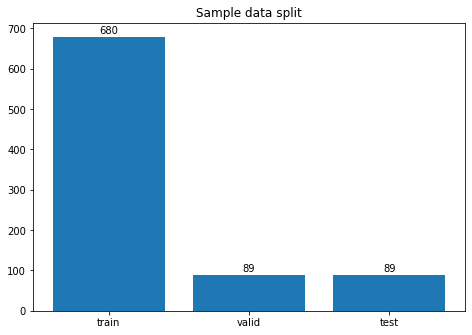

In [9]:
#image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}
train_c = len(image_datasets['train']) #680 #144 vit
valid_c = len(image_datasets['valid']) #89 #22
test_c = len(image_datasets['test']) #89 #21

data_c = {i:len(image_datasets[i]) for i in ['train','valid','test']}

def data_bar_plt(data_c):
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.title.set_text("Sample data split")
  x_axis = list(data_c.keys())
  y_axis = list(data_c.values())
  ax.bar(x_axis,y_axis,color = '#1f77b4')
  for x,y in zip(x_axis,y_axis):
    label = f"{y}"
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,3), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
  plt.show()

data_bar_plt(data_c)

**Single Run** <br>
Execute this if you only want to train model, else, skip to the hyperparameter testing section

In [12]:
#Feature extraction
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 class_token
	 patch_embedding.weight
	 patch_embedding.bias
	 positional_embedding.pos_embedding
	 transformer.blocks.0.attn.proj_q.weight
	 transformer.blocks.0.attn.proj_q.bias
	 transformer.blocks.0.attn.proj_k.weight
	 transformer.blocks.0.attn.proj_k.bias
	 transformer.blocks.0.attn.proj_v.weight
	 transformer.blocks.0.attn.proj_v.bias
	 transformer.blocks.0.proj.weight
	 transformer.blocks.0.proj.bias
	 transformer.blocks.0.norm1.weight
	 transformer.blocks.0.norm1.bias
	 transformer.blocks.0.pwff.fc1.weight
	 transformer.blocks.0.pwff.fc1.bias
	 transformer.blocks.0.pwff.fc2.weight
	 transformer.blocks.0.pwff.fc2.bias
	 transformer.blocks.0.norm2.weight
	 transformer.blocks.0.norm2.bias
	 transformer.blocks.1.attn.proj_q.weight
	 transformer.blocks.1.attn.proj_q.bias
	 transformer.blocks.1.attn.proj_k.weight
	 transformer.blocks.1.attn.proj_k.bias
	 transformer.blocks.1.attn.proj_v.weight
	 transformer.blocks.1.attn.proj_v.bias
	 transformer.blocks.1.proj.weig

In [ ]:
#################################
# Train one model and evaluate
#################################
model_ft, val_hist_acc, val_hist_loss, time_result, best_acc_valid, best_loss_valid = \
train_model(model_ft, dataloaders_dict, criterion, optimizer_ft,  num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/9


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5166 Acc: 0.8309
valid Loss: 0.5300 Acc: 0.8539

Epoch 1/9
train Loss: 0.3894 Acc: 0.8676
valid Loss: 0.3057 Acc: 0.8876

Epoch 2/9
train Loss: 0.3215 Acc: 0.8971
valid Loss: 0.3148 Acc: 0.9101

Epoch 3/9


# **Test**
This section runs the pre-trained model against a set of test images to predict the class. Accuracy of the procedure is then computed on the basis of number of total correct classifications over the total number of images classified.

In [28]:
import sklearn.metrics as sk

# test
def test_model_eval(model, dataloaders, phase):
  # Iterate over data.
  running_corrects = 0
  len_pred = 0
  predicts = []
  true_vals = []
  date = datetime.today().strftime('%Y%m%d')
  time = datetime.today().strftime('%H%M%S')
  
  for inputs, labels in dataloaders[phase]:
      inputs = inputs.to(device)
      labels = labels.to(device) #truths
      model.eval()
      outputs = model(inputs)
      _, prediction = torch.max(outputs, 1) 
      running_corrects += torch.sum(prediction == labels.data)
      
      #Store prediction and lables into cpu list
      for i in prediction.cpu().numpy():
        predicts.append(i)
      for i in labels.data.cpu().numpy():
        true_vals.append(i)
        len_pred += 1
      
  test_acc = running_corrects.double() / len(dataloaders[phase].dataset)
  
  predicts_transformed = predicts.copy()
  true_vals_transformed = true_vals.copy()
  #Process 1,2,3 classes to value of 1 to identify tumor
  for i in range(0,len_pred):
    if (predicts[i] in [1,2,3]):
      predicts_transformed[i] = 1
    if (true_vals[i] in[1,2,3]):
      true_vals_transformed[i] = 1
    
  recall = sk.recall_score(true_vals_transformed, predicts_transformed)
  f1 = sk.f1_score(true_vals, predicts,average='weighted')
  f1_all = sk.f1_score(true_vals, predicts, average=None)

  return test_acc, prediction, recall, f1, f1_all#, true_recall
#Run test model


In [ ]:
#Against test dataset from cross-validation 
test_acc, prediction, recall, f1, f1_all = test_model_eval(model_ft, dataloaders_dict , phase = 'test')
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"Weighted f1: {f1*100:.2f}%")
for i in range(0,len(f1_all)):
  print(f"f1 for class {i}: {f1_all[i]*100:.2f}%")

# **Hyperparameter testing**

## Learning Rate

In [ ]:
#################################
# train multiple models for testing e.g. learning rate
#################################
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

#hyperparameters
learning_list = [0.01, 0.0015, 0.001, 0.0005] #define arbitrary learning elements

def hpt_learning(learning_list, model_ft):
  #initialise storage
  hist_loss_dict = {}
  hist_acc_dict = {}
  time_results = {}

  for i in learning_list.copy():
    #clear memory
    torch.cuda.empty_cache()

    #reinit model_ft:
    model_ft,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
    model_ft = model_ft.to(device)

    #init optimizer
    params_to_update = model_ft.parameters()
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    optimizer_ft = optim.SGD(params_to_update, lr = i, momentum = 0.90)
    
    #train
    since = time.time()
    model_ft, val_hist_acc, val_hist_loss, time_result, best_acc_valid, best_loss_valid = \
    train_model(model_ft, dataloaders_dict, criterion, optimizer_ft,  num_epochs=num_epochs, is_inception=(model_name=="inception"))

    print(f"Training param {i} complete\n")
    hist_loss_dict[i] = val_hist_loss
    hist_acc_dict[i] = [h.cpu().numpy() for h in val_hist_acc]
    time_results[i] = time_result
  return hist_loss_dict, hist_acc_dict, time_results

hloss_d_b, hacc_d_b, time_result = hpt_learning(learning_list, model_ft)

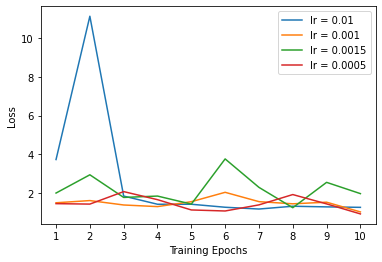

In [ ]:
#################################
# loss
#################################
def hp_plt_loss(loss_val, param_tuned, short_name):
  plt.title(f"Hyperparameter: {param_tuned}")
  plt.xlabel("Training Epochs")
  plt.ylabel("Loss")

  for i in hloss_d:
    plt.plot(range(1,len(loss_val[i])+1), loss_val[i], label = f"{short_name} = {i}")

  plt.ylim((0,1.))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend()
  plt.show()

hp_plt_loss(hloss_d_b,'Learning Rate','lr')

#################################
# accuracy
#################################
def hp_plt_acc(accuracy_val, param_tuned , short_name):
  plt.title(f"Hyperparameter: {param_tuned}")
  plt.xlabel("Training Epochs")
  plt.ylabel("Accuracy(%)")
  for i in hacc_d:
    plt.plot(range(1,len(hacc_d[i])+1), hacc_d[i], label = f"{short_name} = {i}")
  plt.ylim((0,1.))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend()
  plt.show()

hp_plt_acc(hacc_d_b, "Learning Rate","lr")

# **Scratch Comparison**
Comparison against untrained model

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.1865 Acc: 0.5044
valid Loss: 1.3655 Acc: 0.4382

Epoch 1/19
----------
train Loss: 0.8082 Acc: 0.7147
valid Loss: 0.9576 Acc: 0.6517

Epoch 2/19
----------
train Loss: 0.7117 Acc: 0.7382
valid Loss: 0.7663 Acc: 0.7191

Epoch 3/19
----------
train Loss: 0.7503 Acc: 0.7324
valid Loss: 1.2620 Acc: 0.5506

Epoch 4/19
----------
train Loss: 0.6871 Acc: 0.7544
valid Loss: 0.6544 Acc: 0.7528

Epoch 5/19
----------
train Loss: 0.6846 Acc: 0.7721
valid Loss: 0.7796 Acc: 0.7753

Epoch 6/19
----------
train Loss: 0.6777 Acc: 0.7691
valid Loss: 0.6599 Acc: 0.7753

Epoch 7/19
----------
train Loss: 0.5557 Acc: 0.8103
valid Loss: 0.7417 Acc: 0.7079

Epoch 8/19
----------
train Loss: 0.5322 Acc: 0.8147
valid Loss: 0.7499 Acc: 0.7191

Epoch 9/19
----------
train Loss: 0.5093 Acc: 0.8074
valid Loss: 0.5568 Acc: 0.7753

Epoch 10/19
----------
train Loss: 0.5014 Acc: 0.8250
valid Loss: 0.5521 Acc: 0.7865

Epoch 11/19
----------
train Loss: 0.4796 Acc: 0.8426
valid Loss: 0.7034 Acc: 0.7640



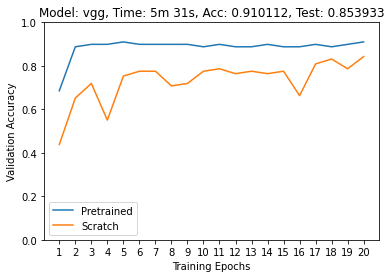

In [ ]:
#################################
# For comparison purpose between non-trained version vs pretrained version.
# Initialize the non-pretrained version of the model used for this run
#################################

scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
# _,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))
_,scratch_hist, _, _ = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))
shist = [h.cpu().numpy() for h in scratch_hist]

# plt.title(f"Validation Accuracy vs. Number of Training Epochs: {model_name}")
plt.title(f"Model: {model_name}, {time_result}")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),hloss_d,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()